Loading Data and Preprocessing:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


# Load historical data for statistical features
historical_data = pd.read_csv('2000-2023_To_Use.csv')

# Assuming your current season schedule data is in a DataFrame called current_season_schedule
current_season_schedule = pd.read_excel('Premier-League-2023_2024-Schedule.xlsx')


# Convert 'Date' columns to datetime format
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
current_season_schedule['Date'] = pd.to_datetime(current_season_schedule['Date'])

# Add a new column 'DayOfWeek' where Monday is 1 and Sunday is 7
historical_data['DayOfWeek'] = historical_data['Date'].dt.dayofweek + 1
current_season_schedule['DayOfWeek'] = current_season_schedule['Date'].dt.dayofweek + 1

# Add a new column 'Day'
historical_data['Day'] = historical_data['Date'].dt.day
current_season_schedule['Day'] = current_season_schedule['Date'].dt.day

# Add a new column 'Month'
historical_data['Month'] = historical_data['Date'].dt.month
current_season_schedule['Month'] = current_season_schedule['Date'].dt.month

# Exclude Luton Town since we do not have any historical data regarding the team
current_season_schedule = current_season_schedule[
    (current_season_schedule['Team'] != 'Luton') & (current_season_schedule['Opp'] != 'Luton')
]

# Convert datetime values to timestamps
historical_data['Date'] = historical_data['Date'].apply(lambda x: x.timestamp())
current_season_schedule['Date'] = current_season_schedule['Date'].apply(lambda x: x.timestamp())





Using the current premier league table rankings as label encoding so that it gives more preference to teams that are in a better league position

In [2]:
class CustomLabelEncoder(LabelEncoder):
    def __init__(self, rank_dict):
        super().__init__()
        self.rank_dict = rank_dict

    def fit(self, y):
        return self

    def transform(self, y):
        return [self.rank_dict[item] for item in y]

    def fit_transform(self, y):
        return self.transform(y)

# My team rankings
team_rankings = {
'Liverpool': 0,
'Arsenal': 1,
'Man City': 2,
'Aston Villa': 3,
'Tottenham': 4,
'Man United': 5,
'Brighton': 6,
'Newcastle': 7,
'West Ham': 8,
'Chelsea': 9,
'Wolves': 10,
'Fulham': 11,
'Bournemouth': 12,
'Brentford': 13,
'Nottingham': 14,
'Crystal Palace': 15,
'Everton': 16,
'Burnley': 17,
'Sheffield United': 18,
'Leicester': 19,
'Leeds': 20,
'Southampton': 21,
'Charlton': 22,
'Coventry': 23,
'Middlesbrough': 24,
'Derby': 25,
'Bradford': 26,
'Sunderland': 27,
'Ipswich': 28,
'Blackburn': 29,
'Bolton': 30,
'West Brom': 31,
'Birmingham': 32,
'Portsmouth': 33,
'Norwich': 34,
'Wigan': 35,
'Watford': 36,
'Reading': 37,
'Stoke': 38,
'Hull': 39,
'Blackpool': 40,
'QPR': 41,
'Swansea': 42,
'Cardiff': 43,
'Huddersfield': 44}

Label Encoding Using Cutomer Encoders created manually 

In [3]:
label_encoder_team = CustomLabelEncoder(team_rankings)
# Define custom label encoders for 'FTR', 'HTR', and 'Venue'
ftr_encoder = CustomLabelEncoder(rank_dict={'Win': 0, 'Draw': 1, 'Loss': 2})
venue_encoder = CustomLabelEncoder(rank_dict={'Home': 0, 'Away': 1})
# Apply custom label encoding to the DataFrame
# Label Encoding
historical_data['Team'] = label_encoder_team.fit_transform(historical_data['Team'])
historical_data['Opp'] = label_encoder_team.fit_transform(historical_data['Opp'])
historical_data['FTR'] = ftr_encoder.fit_transform(historical_data['FTR'])
historical_data['HTR'] = ftr_encoder.fit_transform(historical_data['HTR'])
historical_data['Venue'] = venue_encoder.fit_transform(historical_data['Venue'])

# Similarly, for current_season_schedule DataFrame
current_season_schedule['Team'] = label_encoder_team.transform(current_season_schedule['Team'])
current_season_schedule['Opp'] = label_encoder_team.transform(current_season_schedule['Opp'])
current_season_schedule['Venue'] = venue_encoder.fit_transform(current_season_schedule['Venue'])

# Save the fitted label encoders
joblib.dump(label_encoder_team, 'label_encoder_team.joblib')
joblib.dump(ftr_encoder, 'ftr_encoder.joblib')
joblib.dump(venue_encoder, 'venue_encoder.joblib')


['venue_encoder.joblib']

Predicted Stats for Future Mactches with poisson model using historical data


In [4]:
# Sort by date
historical_data = historical_data.sort_values(by=['Date'])



# Train Poisson regression models for each feature
poisson_models = {}
features_to_predict = ['FTGS_Team', 'HTGS_Team', 'Shots_Team', 'Shots_on_Target_Team', 'FTGS_Opp', 'HTGS_Opp', 'Shots_Opp', 'Shots_on_Target_Opp', 'HTR']

for feature in features_to_predict:
    # Train-test split for Poisson regression
    X_train, X_test, y_train, y_test = train_test_split(
        historical_data[['Team', 'Opp', 'Venue','DayOfWeek','Day','Month']], 
        historical_data[feature], 
        test_size=0.2, 
        random_state=42
    )
    
    # Convert columns to numpy arrays and reshape if needed
    X_train_combined = np.column_stack((
        np.array(X_train['Team']).reshape(-1, 1),
        np.array(X_train['Opp']).reshape(-1, 1),
        np.array(X_train['Venue']).reshape(-1, 1),
        np.array(X_train['DayOfWeek']).reshape(-1, 1),
        np.array(X_train['Day']).reshape(-1, 1),
        np.array(X_train['Month']).reshape(-1, 1)          
    ))
    
    X_test_combined = np.column_stack((
        np.array(X_test['Team']).reshape(-1, 1),
        np.array(X_test['Opp']).reshape(-1, 1),
        np.array(X_test['Venue']).reshape(-1, 1),
        np.array(X_test['DayOfWeek']).reshape(-1, 1),
        np.array(X_test['Day']).reshape(-1, 1),
        np.array(X_test['Month']).reshape(-1, 1)               
    ))

    # Fit Poisson regression model
    poisson_model = sm.GLM(y_train, sm.add_constant(X_train_combined), family=sm.families.Poisson()).fit()
    
    # Predict future values
    future_values = poisson_model.predict(sm.add_constant(
        np.column_stack((
            np.array(current_season_schedule['Team']).reshape(-1, 1), 
            np.array(current_season_schedule['Opp']).reshape(-1, 1),
            np.array(current_season_schedule['Venue']).reshape(-1, 1),
            np.array(current_season_schedule['DayOfWeek']).reshape(-1, 1),
            np.array(current_season_schedule['Day']).reshape(-1, 1),
            np.array(current_season_schedule['Month']).reshape(-1, 1)            
        ))
    ))
    
    # Assign predicted values to current_season_schedule
    current_season_schedule[f'{feature}_poisson'] = future_values
    poisson_models[feature] = poisson_model  # Save the Poisson models for later use

Random forest regressor used to predict the FTR with an option to change the weights of the features affecting the model outcome.
Included Feature importance, Confusion Matrix and Classification matrix


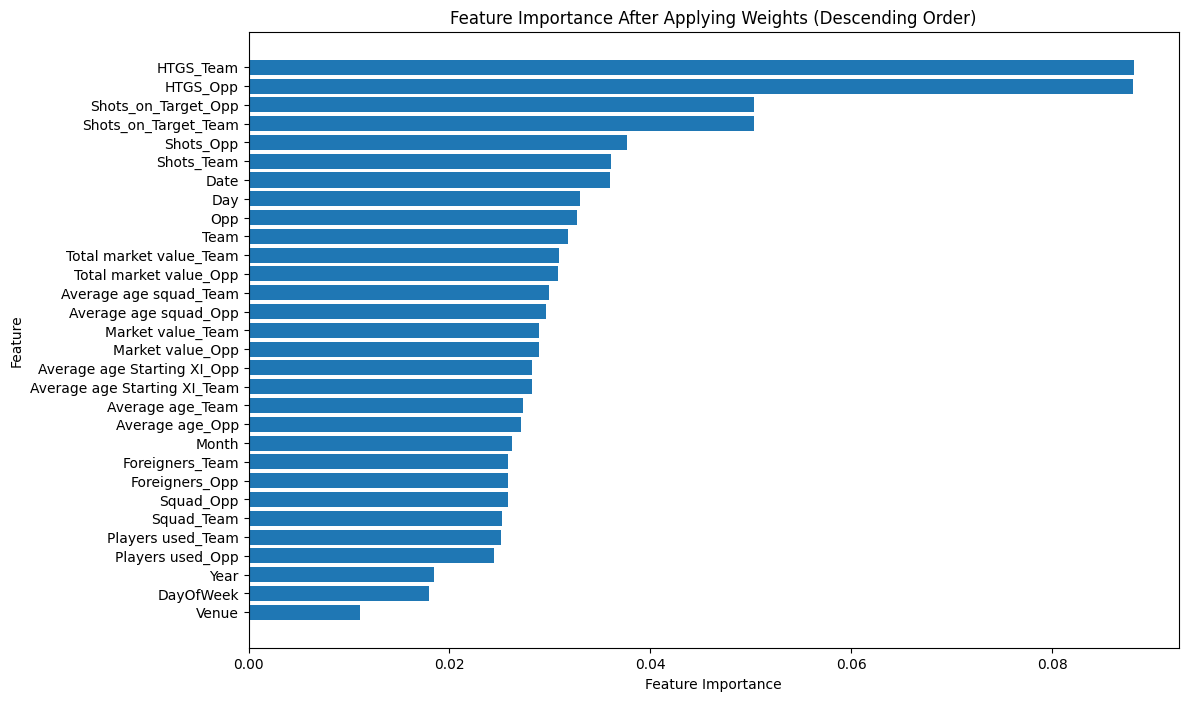

Feature Importances (Descending Order):
HTGS_Team: 0.0881546269373658
HTGS_Opp: 0.08806471016876101
Shots_on_Target_Opp: 0.05030216113226768
Shots_on_Target_Team: 0.05028853089541006
Shots_Opp: 0.03764672502626659
Shots_Team: 0.03612621263185072
Date: 0.035961214756979415
Day: 0.03299703928197815
Opp: 0.032690421203101824
Team: 0.031788048184513494
Total market value_Team: 0.03089752860220122
Total market value_Opp: 0.03078222377142821
Average age squad_Team: 0.0298898142165485
Average age squad_Opp: 0.029653569264911864
Market value_Team: 0.028926816392660083
Market value_Opp: 0.02889362611280209
Average age Starting XI_Opp: 0.02824432986029257
Average age Starting XI_Team: 0.028182158450916307
Average age_Team: 0.0273020791590332
Average age_Opp: 0.027134458251100824
Month: 0.026229099225975664
Foreigners_Team: 0.025848809617134167
Foreigners_Opp: 0.02581258990015294
Squad_Opp: 0.02578316396508914
Squad_Team: 0.025243058559368262
Players used_Team: 0.025171752689599203
Players used_O

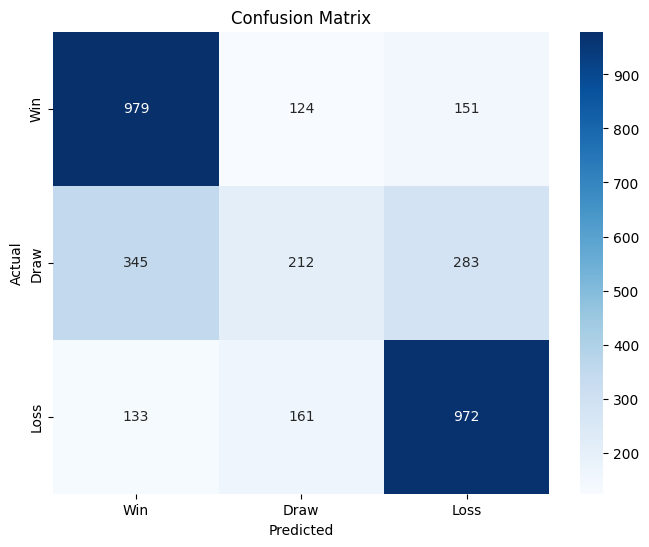

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      1254
           1       0.43      0.25      0.32       840
           2       0.69      0.77      0.73      1266

    accuracy                           0.64      3360
   macro avg       0.60      0.60      0.59      3360
weighted avg       0.62      0.64      0.62      3360



In [5]:


# Assuming you have added the "_poisson" suffix to column names
columns_to_remove_suffix = [col for col in current_season_schedule.columns if col.endswith("_poisson")]

# Remove the "_poisson" suffix from column names
current_season_schedule.columns = [col.replace("_poisson", "") if col.endswith("_poisson") else col for col in current_season_schedule.columns]
# Drop the 'Matchday' column from current_season_schedule
current_season_schedule.drop(columns=['Matchday'], inplace=True)

# Separate features and target variable for classification task
X = historical_data[['DayOfWeek','Year', 'Date','Day','Month','Team', 'Opp', 'Venue', "Squad_Team", 'Players used_Team', 'Average age squad_Team',
'Average age Starting XI_Team', 'Average age_Team', 'Foreigners_Team', 'Market value_Team', 'Total market value_Team',"Squad_Opp", 'Players used_Opp', 'Average age squad_Opp',
'Average age Starting XI_Opp', 'Average age_Opp', 'Foreigners_Opp', 'Market value_Opp', 'Total market value_Opp', 'HTGS_Team', 'Shots_Team', 'Shots_on_Target_Team', 'HTGS_Opp', 'Shots_Opp', 'Shots_on_Target_Opp']]
y = historical_data['FTR']  # Use 'FTR' from historical data for training

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Random Forest Classifier model
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Calculate feature importances before applying weights
classifier.fit(X_train, y_train)
feature_importances_before = classifier.feature_importances_

# Define feature weights
feature_weights = {
    'DayOfWeek': 1.0,
    'Year': 1.0,
    'Date': 1.0,
    'Day': 1.0,
    'Month': 1.0,
    'Team': 1.0,
    'Opp': 1.0,
    'Venue': 1.0,
    'Squad_Team': 1.0,
    'Players used_Team': 1.0,
    'Average age squad_Team': 1.0,
    'Average age Starting XI_Team': 1.0,
    'Average age_Team': 1.0,
    'Foreigners_Team': 1.0,
    'Market value_Team': 1.0,
    'Total market value_Team': 1.0,
    'Squad_Opp': 1.0,
    'Players used_Opp': 1.0,
    'Average age squad_Opp': 1.0,
    'Average age Starting XI_Opp': 1.0,
    'Average age_Opp': 1.0,
    'Foreigners_Opp': 1.0,
    'Market value_Opp': 1.0,
    'Total market value_Opp': 1.0,
    'HTGS_Team': 1.1,
    'Shots_Team': 1.0,
    'Shots_on_Target_Team': 1.0,
    'HTGS_Opp': 1.1,
    'Shots_Opp': 1.0,
    'Shots_on_Target_Opp': 1.0,

}

# Apply feature weights to the features in X_train and X_test
X_train_weighted = X_train.copy()
X_test_weighted = X_test.copy()
for feature, weight in feature_weights.items():
    X_train_weighted[feature] *= weight
    X_test_weighted[feature] *= weight

# Fit the model on the weighted training data
classifier.fit(X_train_weighted, y_train)

# Extract feature importances after applying weights
feature_importances_after = classifier.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances_after)
sorted_feature_importances = feature_importances_after[sorted_indices]
sorted_features = np.array(X.columns)[sorted_indices]

# Visualize the feature importance after applying weights
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance After Applying Weights (Descending Order)')
plt.show()

# Print feature importances in descending order
print("Feature Importances (Descending Order):")
for idx in reversed(sorted_indices):
    print(f"{X.columns[idx]}: {feature_importances_after[idx]}")

# Predict on the weighted test data
y_pred = classifier.predict(X_test_weighted)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
class_labels = ['Win', 'Draw', 'Loss']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Features should be in the same order as seen at fit
current_season_schedule = current_season_schedule[['DayOfWeek','Year', 'Date','Day','Month','Team', 'Opp', 'Venue', "Squad_Team", 'Players used_Team', 'Average age squad_Team',
'Average age Starting XI_Team', 'Average age_Team', 'Foreigners_Team', 'Market value_Team', 'Total market value_Team',"Squad_Opp", 'Players used_Opp', 'Average age squad_Opp',
'Average age Starting XI_Opp', 'Average age_Opp', 'Foreigners_Opp', 'Market value_Opp', 'Total market value_Opp', 'HTGS_Team', 'Shots_Team', 'Shots_on_Target_Team', 'HTGS_Opp', 'Shots_Opp', 'Shots_on_Target_Opp']]

# Predict on the current season schedule data
current_season_predictions = classifier.predict(current_season_schedule)

# Add the predictions to the current season schedule DataFrame
current_season_schedule['Predicted_FTR'] = current_season_predictions


Transform labels back to the original categorical names from numeric.


In [6]:

# Load the fitted label encoders
label_encoder_team = joblib.load('label_encoder_team.joblib')
ftr_encoder = joblib.load('ftr_encoder.joblib')
venue_encoder = joblib.load('venue_encoder.joblib')

# Define a reverse mapping dictionary to map numeric values back to original labels
reverse_team_rankings = {v: k for k, v in team_rankings.items()}
reverse_ftr_rankings = {v: k for k, v in ftr_encoder.rank_dict.items()}
reverse_venue_rankings = {v: k for k, v in venue_encoder.rank_dict.items()}


# Inverse transform 'Team' 'Opp' 'Venue' and 'FTR'  columns
current_season_schedule['Team'] = current_season_schedule['Team'].map(reverse_team_rankings)
current_season_schedule['Opp'] = current_season_schedule['Opp'].map(reverse_team_rankings)
current_season_schedule['Predicted_FTR'] = current_season_schedule['Predicted_FTR'].map(reverse_ftr_rankings)
current_season_schedule['Venue'] = current_season_schedule['Venue'].map(reverse_venue_rankings)

# Define a function to calculate points based on the predicted result
def calculate_points(result):
    if result == 'Win':
        return 3
    elif result == 'Draw':
        return 1
    else:
        return 0

# Apply the function to create a new column for points
current_season_schedule['Points'] = current_season_schedule['Predicted_FTR'].apply(calculate_points)


# Save the transformed data to an Excel file
current_season_schedule.to_excel('Prediction_Season_2023-2024.xlsx', index=False)


Check Total Points

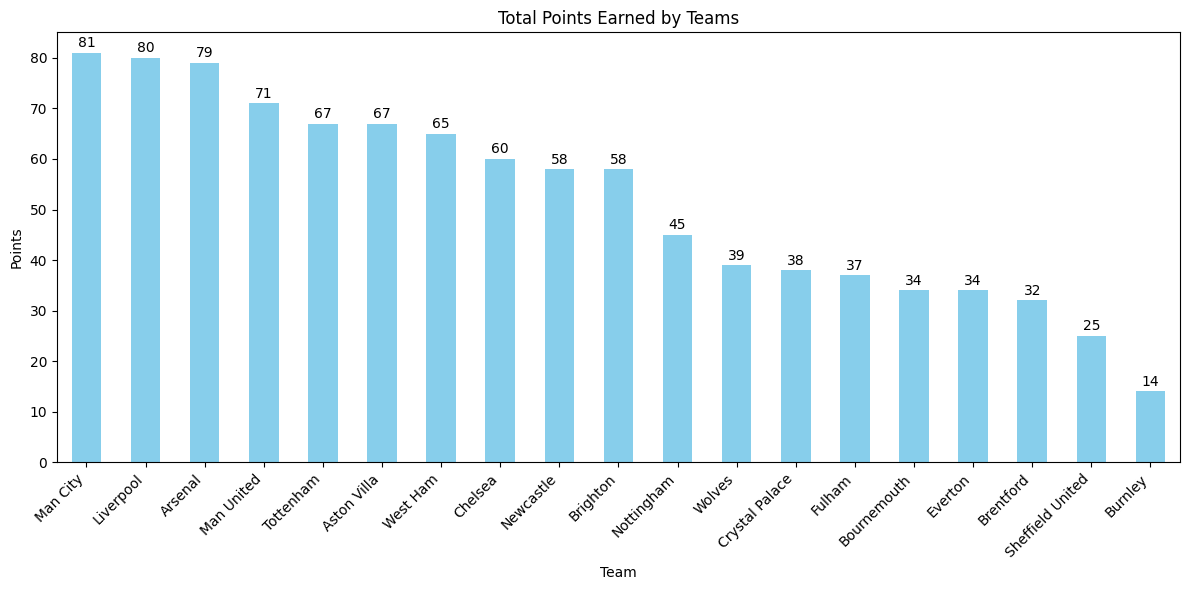

In [7]:
# Create a pivot table with Team as rows, Predicted_FTR as columns, and Opp as values (count)
pivot_table = current_season_schedule.pivot_table(index='Team', columns='Predicted_FTR', values='Opp', aggfunc='count', fill_value=0)

# Reorder the columns so that 'Win' appears before 'Draw'
column_order = ['Win', 'Draw', 'Loss']
pivot_table = pivot_table.reindex(column_order, axis=1)

# Sort the pivot table columns in descending order by the count of wins
pivot_table = pivot_table.sort_values(by='Win', ascending=False)

# Calculate the sum of points for each team
pivot_table['Points'] = pivot_table['Win'] * 3 + pivot_table['Draw']

# Plot the bar chart for total points
plt.figure(figsize=(12, 6))
pivot_table_points_sorted = pivot_table.sort_values(by='Points', ascending=False)
bar_plot_points = pivot_table_points_sorted['Points'].plot(kind='bar', color='skyblue')
plt.xlabel('Team')
plt.ylabel('Points')
plt.title('Total Points Earned by Teams')
plt.xticks(rotation=45, ha='right')
# Add total points on the bars
for i, v in enumerate(pivot_table_points_sorted['Points']):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()



Check Win Draw and Loss

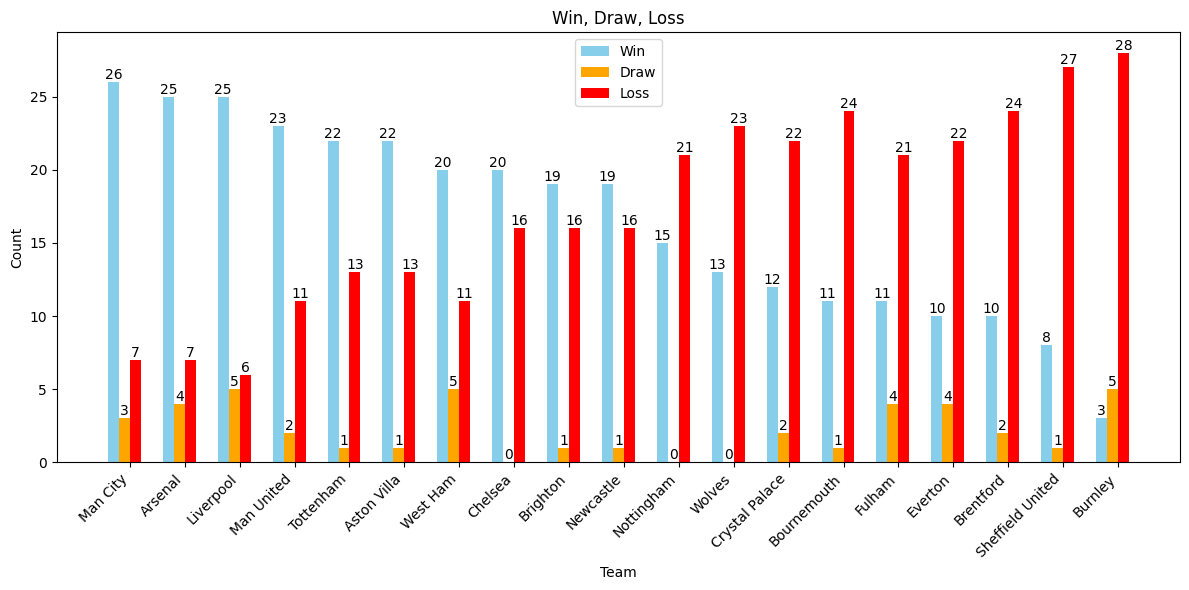

In [8]:
# Plot the bar chart for Win, Draw, Loss
plt.figure(figsize=(12, 6))
bar_width = 0.2
bar_indices = np.arange(len(pivot_table))
win_bars = plt.bar(bar_indices, pivot_table['Win'], bar_width, color='skyblue', label='Win')
draw_bars = plt.bar([i + bar_width for i in bar_indices], pivot_table['Draw'], bar_width, color='orange', label='Draw')
loss_bars = plt.bar([i + 2 * bar_width for i in bar_indices], pivot_table['Loss'], bar_width, color='red', label='Loss')
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Win, Draw, Loss')
plt.xticks([i + 1.5 * bar_width for i in bar_indices], pivot_table.index, rotation=45, ha='right')

# Add counts on the bars
for bars in [win_bars, draw_bars, loss_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()